In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
print(tf.__version__)

2.0.0


In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
imdb = keras.datasets.imdb
# 参数num_words=10000保留训练数据中最常出现的10000个单词，保持了数据规模可管理性。
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 7s 0us/step


In [6]:
# 探索数据：了解数据格式
print("训练实体：{0},标签：{1}".format(len(train_data), len(train_labels)))

训练实体：25000,标签：25000


In [7]:
# 评论文本被转换为整数数值，其中每个整数代表词典中的一个单词。看一下第一条评论：
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [8]:
# 评论明显可能有不同长度，如下。
# 但由于神经网络的输入必须是统一的长度，我们稍后还要解决这个问题。
len(train_data[0]), len(train_data[1])

(218, 189)

##### 将整数转换回单词
-------
1. 很有必要了解将整数转换回文本的方法。
2. 这里创建一个辅助函数来查询包含了整数-字符串映射的字典对象

In [10]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [11]:
# 现在我们可以使用decode_review 函数来显示第一条评论的文本信息：
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

##### 准备数据——影评即整数数组必须在输入神经网络前转换为张量，有一下两种方式
----------
1. 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 num_words * num_reviews 的矩阵。
2. 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 max_length * num_reviews 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。
----------
将使用第二种方法，并使用pad_sequences函数来使得输入神经网络的评论长度标准化。

In [16]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding='post',
                                                      maxlen=256)

In [17]:
# 看下样本长度
len(train_data[0]), len(train_data[1])

(256, 256)

In [18]:
# 并检查第一条评论（应该已被填充）
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

##### 构建模型
------------
神经网络由堆叠的层来构建，这需要从两个主要方面来进行体系结构决策：
1. 模型有多少层？
2. 每个层有多少隐藏层单元(hidden units)？
------------
在此样本中，输入数据包含一个单词索引(映射的整形数值)的数组，而要预测的标签为0或1。
-------
为该问题构建以下模型：

In [19]:
# 输入形状是用于电影评论的词汇数目（10,000词）
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


##### 层按顺序堆叠以构建分类器：
---------
1. （需要理解原理）第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（Embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度，得到的维度为（batch,sequence,embedding）
2. 接下来，GlobalAveragePooling1D将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这样允许模型以尽可能最简单的方式处理变长输入。
3. 该定长输出向量通过一个具有16个隐藏层单元的券链接（Dense）层传输。
4. 最后一层与单个输出结点密集连接。使用Sigmoid激活函数，其函数值为介于0-1之间的浮点数，表示概率/置信度。

##### 隐藏层单元
--------------
1. 上述模型在输入输出之间有两个中间层/“隐藏层”。输出（单元，结点/神经元）的数量即为表示空间的维度。换句话说，是学习内部表示时网络所允许的自由度。
2. 如果模型具有更多的隐藏层单元（即更高维度的表示空间）和/或 更多层，则可以学习到更复杂的表示。但是，这会使网络的计算成本更高，而且可能导致学习到不需要的模式————比如一些能在训练数据上而不是在测试数据上改善性能的模式，也就是过拟合。

##### 损失函数与优化器
------
1. 一个模型需要损失函数和优化器来进行训练。因为这是一个而分类问题且模型输出的是概率值（一个使用sigmoid激活函数的单一单元层），我们将使用binary_crossentropy损失函数。
2. 当然这不是损失函数的唯一一个选择，例如，也可以选择mean_squared_error。但一般来说，binary_crossentropy更适合处理概率——其能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量ground-truth分布？与预测值之间的“距离”。

In [20]:
# 现在，配置模型来使用优化器和损失函数：
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

#####  创建一个验证集
----------
在训练时，我们想要检查模型在未坚果的数据上的准确率（accuracy）。通过从原始训练数据中分离10,000个样本来创建一个验证集。（目的：只使用训练数据来开发和调整模型，然后只使用一次测试数据来评估准确率Acc）

In [23]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

##### 训练模型
-------------
1. 以512个样本的mini-batch大小迭代40个epoch来训练模型。
2. 这指的是对x_train和y_train张量中所有样本的40次迭代。
3. 在训练过程中，检测来自验证集的10,000个样本上的损失值loss和准确率acc

In [24]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1
                   )

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 57us/sample - loss: 0.6918 - accuracy: 0.5697 - val_loss: 0.6898 - val_accuracy: 0.6769
Epoch 2/40
15000/15000 [==============================] - 0s 17us/sample - loss: 0.6861 - accuracy: 0.7201 - val_loss: 0.6822 - val_accuracy: 0.7353
Epoch 3/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.6746 - accuracy: 0.7511 - val_loss: 0.6679 - val_accuracy: 0.7293
Epoch 4/40
15000/15000 [==============================] - 0s 19us/sample - loss: 0.6557 - accuracy: 0.7702 - val_loss: 0.6469 - val_accuracy: 0.7705
Epoch 5/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.6287 - accuracy: 0.7926 - val_loss: 0.6183 - val_accuracy: 0.7769
Epoch 6/40
15000/15000 [==============================] - 0s 20us/sample - loss: 0.5941 - accuracy: 0.8027 - val_loss: 0.5837 - val_accuracy: 0.7956
Epoch 7/40
15000/15000 [==============================] 

##### 评估模型
------------
看一下模型性能。返回两个值：loss损失（表示误差，值低了好）与acc准确率

In [25]:
results = model.evaluate(test_data, test_labels, verbose=2)

print(results)

25000/1 - 0s - loss: 0.3274 - accuracy: 0.8744
[0.3194321419095993, 0.87436]


In [26]:
# 这种十分朴素的方法得到了约 87% 的准确率（accuracy）。若采用更好的方法，模型的准确率应当接近 95%。

##### 创建一个准确率（accuracy）和损失值（loss）随时间变化的图表
-----------
model.fit()返回一个History对象，该对象包含一个字典，其中包含训练阶段所发生的所有事件：

In [27]:
history_dict= history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
# 有四个items：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失loss和准确率acc，以便来进行比较。

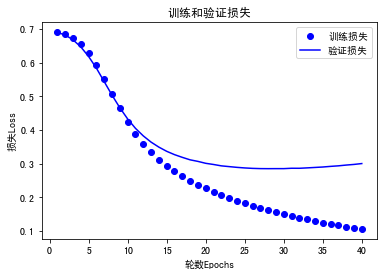

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"代表“蓝点”
plt.plot(epochs, loss, 'bo', label='训练损失')
# 'b'代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='验证损失')
plt.title('训练和验证损失')
plt.xlabel('轮数Epochs')
plt.ylabel('损失Loss')
plt.legend()

plt.show()

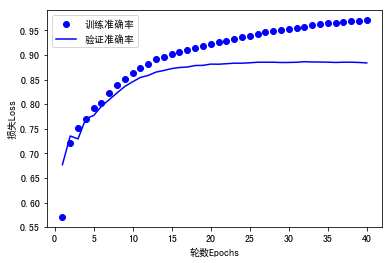

In [33]:
plt.clf()  # 清除数字
plt.plot(epochs, acc, 'bo', label='训练准确率')
plt.plot(epochs, val_acc, 'b', label='验证准确率')
plt.xlabel('轮数Epochs')
plt.ylabel('损失Loss')
plt.legend()

plt.show()

1. 由图，损失值loss随着epoch下降下降；acc随着每一个epoch上升。这在使用梯度下降优化时是可预期的——理应在每次迭代中最小化期望值。
2. 但验证过程中的损失和acc却并非如此——似乎它们在20个epoch后达到峰值——这是过拟合的一个实例：模型在训练数据上的表现比在从未见过的数据上的变现要更好，在此之后，模型过度优化并学习特定于训练数据的表示从而不能够泛化到测试数据。
3. 对于这种特殊情况，我们可以通过20个左右的epoch后停止训练来避免过拟合。之后将有通过“回调”来自动执行此操作。

### 这是来自https://tensorflow.google.cn/tutorials/keras/text_classification 的教程
------
子标题位于BEGINNER下ML basics with Keras下的Text classification with preprocessed text里。